### Step 1: Data Loading and Initial Exploration

Let's start by loading the data and inspecting the first few rows.

In [16]:
import pandas as pd
import gzip

# Load column names
with open("data/kddcup.names", 'r') as f:
    lines = f.readlines()[1:]  # Skipping the first line
    columns = [line.split(":")[0] for line in lines]
columns.append("label")

# Load the 10% dataset
with gzip.open("data/kddcup.data_10_percent.gz", 'rt') as f:
    df = pd.read_csv(f, names=columns)

# Display the first few rows
df.head()
df.shape

(494021, 42)

### Step 2: Data Visualization and Exploration

Before converting the data into a graph structure, it's beneficial to understand the data distribution and the types of network connections.

#### 2.1 Visualization of Connection Types

Let's visualize the distribution of connection types (labels) in the dataset.

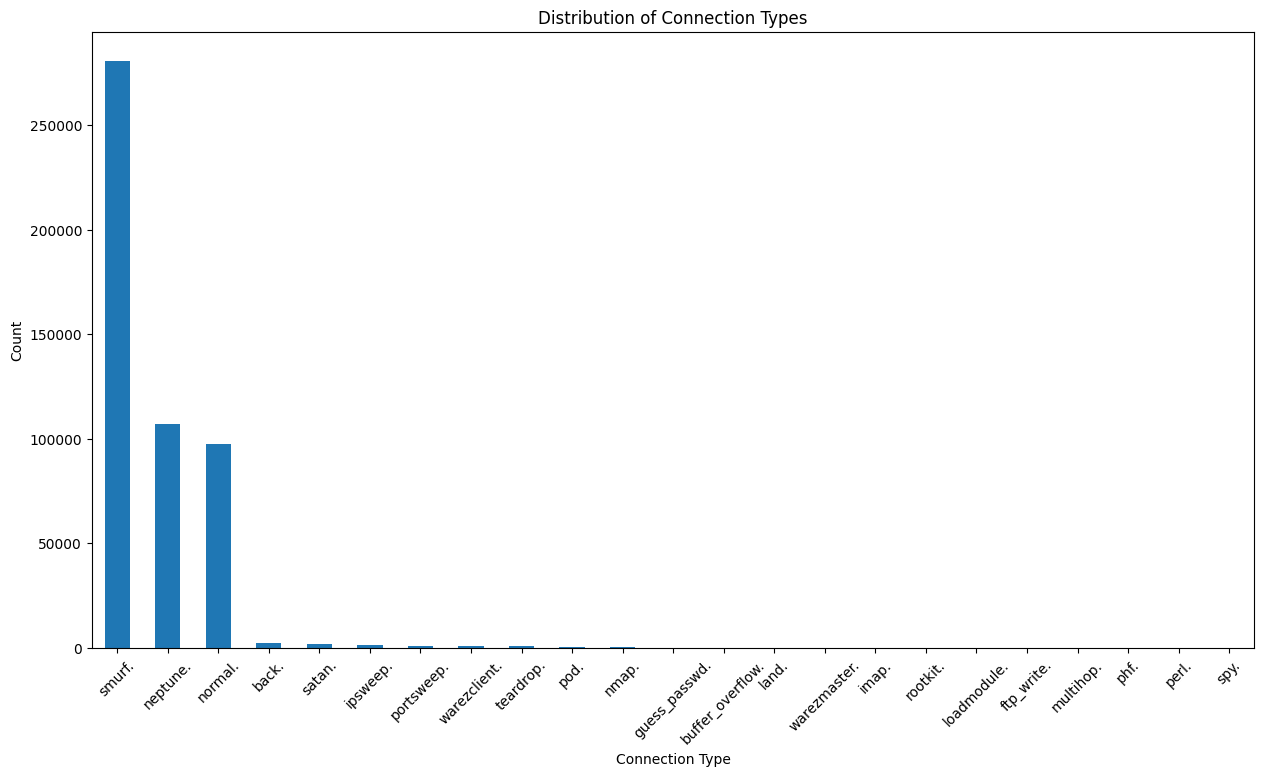

In [17]:
import matplotlib.pyplot as plt

# Distribution of connection types
plt.figure(figsize=(15, 8))
df['label'].value_counts().plot(kind='bar')
plt.title("Distribution of Connection Types")
plt.ylabel("Count")
plt.xlabel("Connection Type")
plt.xticks(rotation=45)
plt.show()

This visualization will show how many instances of each connection type are in the dataset.

#### 2.2 Visualization of Protocol Types

We can also visualize the distribution of different protocol types.

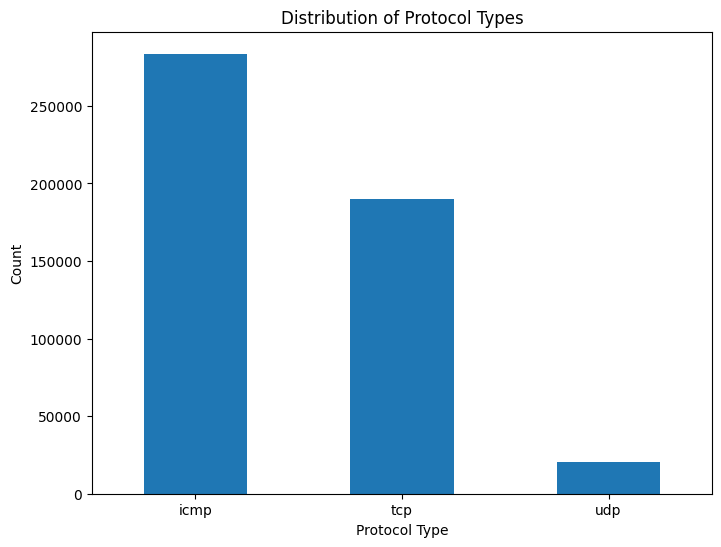

In [18]:
plt.figure(figsize=(8, 6))
df['protocol_type'].value_counts().plot(kind='bar')
plt.title("Distribution of Protocol Types")
plt.ylabel("Count")
plt.xlabel("Protocol Type")
plt.xticks(rotation=0)
plt.show()

### Step 3: Convert Data into Graph Structure

To represent this data as a graph:

- **Nodes**: Ideally, we'd use source and destination IP addresses (or hosts) as nodes. However, the KDD dataset doesn't provide explicit IP addresses. We'll use a combination of features to represent nodes.
- **Edges**: Connections between these nodes. Edge weights can be based on features like `duration`.

For simplicity:
1. We can treat each row as an edge.
2. Source and destination can be represented by a combination of features to uniquely identify nodes (e.g., `src_bytes` and `dst_bytes`).

Let's represent the graph visually:

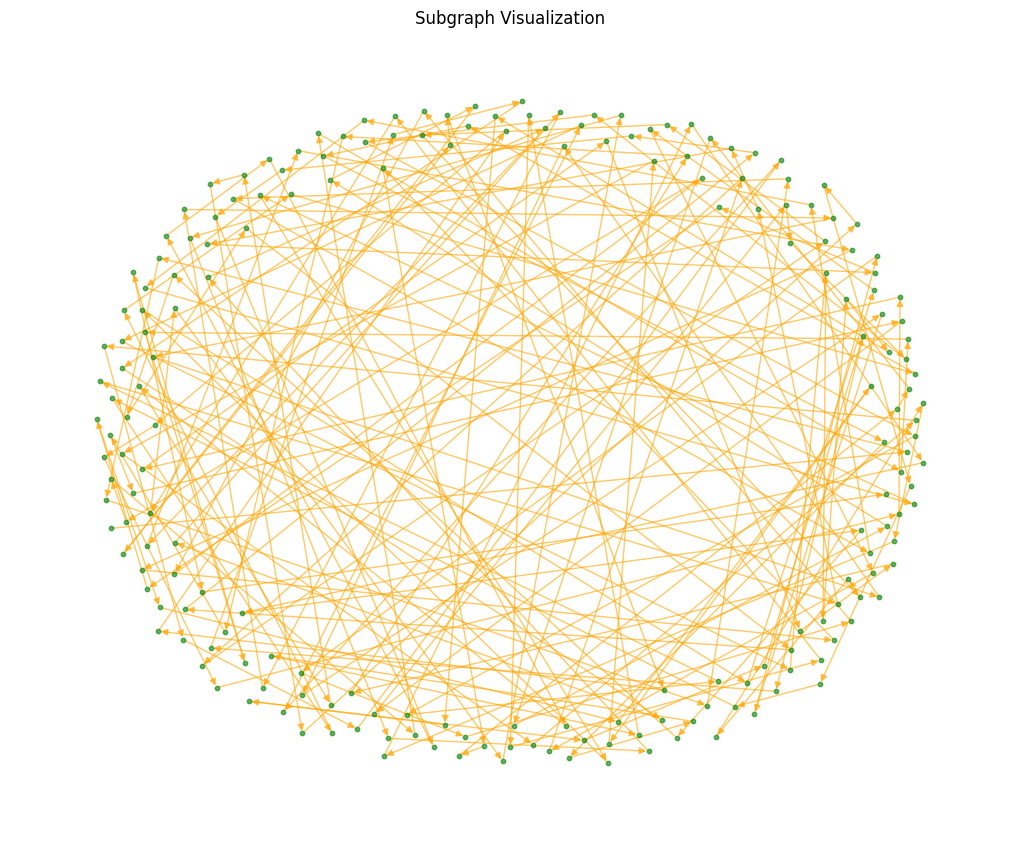

In [19]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph from the data
# Here, we're considering each row as a unique connection
# and using index as a proxy for unique source and destination nodes.
for index, row in df.iterrows():
    G.add_edge(index, index + 1, weight=row['duration'], label=row['label'])

# Visualize a subgraph for clarity
plt.figure(figsize=(10, 8))
subgraph = G.subgraph(list(G.nodes())[:200])  # Taking the first 200 nodes for visualization
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=False, node_size=10, node_color="green", edge_color="orange", alpha=0.6)
plt.title("Subgraph Visualization")
plt.show()

### Step 4: Making the Graph Dynamic

To make the graph dynamic, we'll segment the data into sequential chunks or intervals. Each chunk will represent a snapshot of the network at a given time.

For simplicity, let's split the dataset into 10 intervals. Each interval will represent a different snapshot of the network. This will create a dynamic representation of the network over time.

#### 4.1 Splitting the Data into Intervals

In [20]:
num_intervals = 10
interval_size = len(df) // num_intervals

graph_snapshots = []

for i in range(num_intervals):
    interval_df = df.iloc[i * interval_size: (i + 1) * interval_size]
    G_interval = nx.DiGraph()

    for index, row in interval_df.iterrows():
        G_interval.add_edge(index, index + 1, weight=row['duration'], label=row['label'])

    graph_snapshots.append(G_interval)

#### 4.2 Visualizing a Graph Snapshot

It's useful to visualize one of the graph snapshots to get a sense of its structure. Let's visualize the first snapshot:

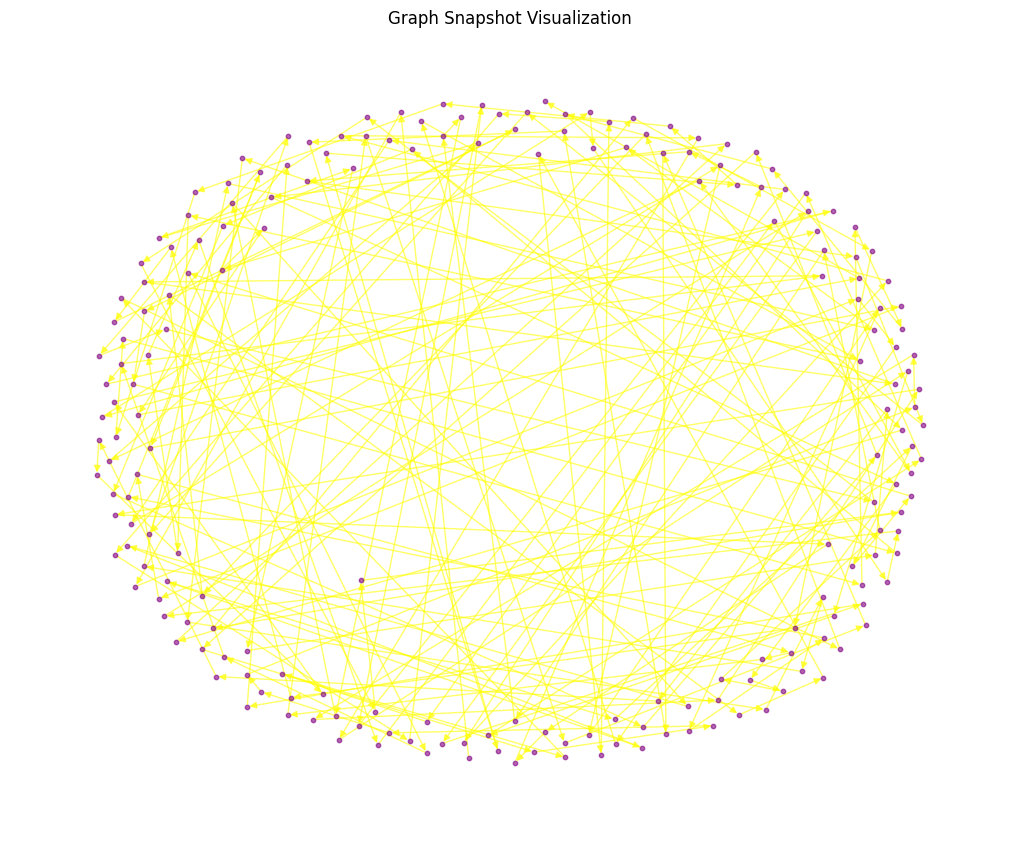

In [21]:
plt.figure(figsize=(10, 8))
subgraph_snapshot = graph_snapshots[0].subgraph(list(graph_snapshots[0].nodes())[:200])  # Taking the first 200 nodes for visualization
pos_snapshot = nx.spring_layout(subgraph_snapshot)
nx.draw(subgraph_snapshot, pos_snapshot, with_labels=False, node_size=10, node_color="purple", edge_color="yellow", alpha=0.6)
plt.title("Graph Snapshot Visualization")
plt.show()

### Step 5: Applying Dynamic Graph Embeddings

With the dynamic graph in place, we'll apply graph embeddings to represent the graph structure in a format suitable for machine learning. We'll use the Node2Vec approach for this purpose.

#### 5.1 GraphSAGE (Graph Sample and Aggregation)

For each graph snapshot, we'll generate GraphSAGE embeddings.

In [ ]:
import numpy as np
from scipy.sparse.linalg import eigs

def laplacian_eigenmaps(graph, dimensions=64):
    # Convert the graph to undirected
    undirected_graph = graph.to_undirected()

    # Compute the normalized Laplacian
    L = nx.normalized_laplacian_matrix(undirected_graph)

    # Compute the eigenvectors
    _, vecs = eigs(L, k=dimensions+1, which='SM')

    # Discard the first (smallest) eigenvector and use the rest as the embeddings
    embeddings = vecs[:, 1:]
    return embeddings

# Compute embeddings for the first graph snapshot as a demo
embeddings_demo = laplacian_eigenmaps(graph_snapshots[0])

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


### Step 6: Anomaly Detection using Isolation Forest

With the embeddings obtained, we can use them as features for the Isolation Forest model to detect anomalies. The Isolation Forest is particularly suitable for anomaly detection because it's designed to detect rare instances by isolating them.

Here's how you can apply the Isolation Forest model:

#### 6.1 Preparing the Data
First, you'll need to prepare the embeddings and the labels. For this demonstration, we'll consider "normal" as the non-anomalous class and all other labels as anomalies.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Get nodes from the largest connected component of the first graph snapshot
largest_cc_nodes = list(max(nx.connected_components(graph_snapshots[0].to_undirected()), key=len))

# Filter labels to only include those nodes
filtered_labels = df.loc[largest_cc_nodes, 'label'].values
filtered_labels = (filtered_labels != 'normal.').astype(int)

# For simplicity, we'll use embeddings from the first graph snapshot
X = embeddings_demo

#### 6.2 Splitting the Data into Training and Testing Sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, filtered_labels, test_size=0.3, random_state=42)

#### 6.3 Training the Isolation Forest Model

In [ ]:
from sklearn.ensemble import IsolationForest

# Train the Isolation Forest model
clf = IsolationForest(contamination=0.3, random_state=42)
clf.fit(X_train)

The error indicates that the embeddings (X) have complex values, which aren't supported by the Isolation Forest algorithm (or many other Scikit-learn algorithms). This issue arises because the eigs function, used in the Laplacian Eigenmaps method, can return complex-valued eigenvectors.

To address this, you can take the real part of the embeddings, effectively discarding the imaginary components. This is a common approach when dealing with complex-valued embeddings or eigenvectors in machine learning tasks.

In [ ]:
X_real = X.real
X_real

In [ ]:
from sklearn.ensemble import IsolationForest

# Train the Isolation Forest model
clf = IsolationForest(contamination=0.3, random_state=42)
clf.fit(X_real)

#### 6.4 Making Predictions and Evaluating the Model

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

X_real_test = X_test.real

# Predict anomalies on the test set
y_pred = clf.predict(X_real_test)

# Convert the predictions from {-1, 1} to {1, 0}
y_pred = (y_pred == -1).astype(int)

# Evaluate the model
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Report: {report}")
print(f"Accuracy: {accuracy}")